In [1]:
import scipy
print('scipy: {}'.format(scipy.__version__)) # numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib
import datetime


import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__)) # pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
#scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
import xlrd
from sklearn.preprocessing import Imputer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, Ridge  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection #might be model_selection <--- this is the new one
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
import seaborn as sns
import xgboost as xgb
import zipcode
import geopy
from geopy.geocoders import Nominatim
from geopy.distance import vincenty

sns.set_style("whitegrid")
%matplotlib inline

scipy: 0.19.1
numpy: 1.12.1
matplotlib: 2.0.2
pandas: 0.20.3
sklearn: 0.19.0


C:\Users\SuperBug\Anaconda2\envs\mdg\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option("display.max_columns",500)

In [40]:
data = pd.read_csv('SuperZooData/Registration_Data/SuperZoo_2016_Registrants_No_Minors.csv', header = 2)

In [4]:
test_data = pd.read_csv('SuperZooData/Registration_Data/SuperZoo_2017_Registrants_No_Minors.csv', header = 2)

C:\Users\SuperBug\Anaconda2\envs\mdg\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (39,40,43,62,63,84,120,121,145,146,148,149,160,161,191,192,224,225,227,228,236,237,269,270,272,273,275,276,284,285,344,346,350,352,353,360,361,373,385,386,387) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
def dups_with_dif_index_check(data):
    dupes = {}                        # checks to see if duplicated columns with different index values
    for col_a in data.columns:
        dupes[col_a] = []

        for col_b in data.columns:
            if col_b in dupes.keys():
                continue
            if (data.loc[:,col_a] == data.loc[:,col_b]).sum() == len(data.loc[:,col_a]):
                dupes[col_a].append(col_b)    
   
    bad_cols = []   
    for col, dup_cols in dupes.iteritems():
        bad_cols += dup_cols
    bad_cols = set(bad_cols)

    data = data.loc[:,~data.columns.isin(bad_cols)]
    return data

In [6]:
def clear_dups_na(data):
    data = data.loc[:,~data.columns.duplicated()] 
    data = data.dropna(axis=1, how='all')
    data = data.dropna(axis=0, how='all')
    data = dups_with_dif_index_check(data)
    return data

In [7]:
def def_time_modify(data, date_checker):
    data["AddDate Date"] = pd.to_datetime(data["AddDate Date"])
    data['ModifyDate Date'] = pd.to_datetime(data['ModifyDate Date'])
    for a in range(0,len(data.iloc[:,data.columns.get_loc('ModifyDate Date')])):
        if data.iloc[a,data.columns.get_loc('ModifyDate Date')] > date_checker:
            data.iloc[a,data.columns.get_loc('ModifyDate Date')] = data.iloc[a,data.columns.get_loc("AddDate Date")]
    return data

In [8]:
def date_time_update(data, date_checker):
    data = data[data["AddDate Date"] <= date_checker]
    return data
    

In [9]:
def data_drop_other_text(data):
    col = []
    for a in data.columns:
        if "_text" in a or "_other" in a:
            col.append(a)
    data=data.drop(labels = col, axis =1)
    return data

In [10]:
def get_rid_of_nonnumerical_answer(data):
    col = [] # THIS NEEDS TO BE CHANGED FOR NEW DATA SET
    checker = 1
    for a in data.columns:
        if '_codes' in a and checker ==1:
            checker = 0
        if '_codes' not in a and checker == 0:
            col.append(a)
    data = data.drop(col, axis = 1)
    return data

In [11]:
def answers_dummies(data):
    column =[]
    for a in data.columns:
        if "_codes" in a:
            column.append(a)  
    for a in column:
        new_data = data[a].str.get_dummies(sep=',')
        data = pd.concat([data, new_data], axis=1)
        data = data.drop([a], axis = 1)
    return data
    

In [12]:
def data_change_string_drop_dups(data):
    for a in data.columns:
        if data[a].dtype== np.dtype('O'):
            data[a] = data[a].astype('S32')
    cols = list(data)    # THIS DROPS ALL COLUMNS THAT HAVE THE SAME VALUE
    nunique = data.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    data = data.drop(cols_to_drop, axis=1)
    return data

In [13]:
def purchase_dummies(data):
    new_data = data['PurchaseItems'].str.get_dummies(sep=',')
    data = pd.concat([data, new_data], axis=1)
    data = data.drop(['PurchaseItems'], axis = 1)
    return data 

In [14]:
def state_dummies(data):
    s = data.State.value_counts()
    s = data.State.value_counts()[s > (8)].index #8
    holder = pd.get_dummies(data.State)
    holder_smaller = holder[s]
    data = pd.concat([data, holder_smaller], axis=1)
    return data

In [15]:
def check_zip(data):
    data.loc[data.loc[:,'ZipPostal'].str.contains('-', na = False),'ZipPostal'] = data.loc[data.loc[:,'ZipPostal'].str.contains('-', na = False),'ZipPostal'].str.split('-',n = 1, expand = True)[0]
    return data

In [16]:
def zip_distance(data):
    data = check_zip(data)
    geolocator = Nominatim()
    vegas = zipcode.isequal('89178')
    veg = (vegas.lat, vegas.lon)
    col= []
    for idx, val in enumerate (data.ZipPostal):
        try:
            city = zipcode.isequal(val)
            cit = (city.lat, city.lon)
            col.append(vincenty(veg, cit).miles)
        except:
            try:
                city = geolocator.geocode(data.loc[idx,'Country']+" "+val)
                cit = (city.latitude, city.longitude)
                col.append(vincenty(veg, cit).miles)
            except:
                col.append('nan')
    data.insert(0, 'Distance', col, allow_duplicates=False)
   
    return data

In [17]:
def company_name(data):
    data.Company = data.Company.str.lower()
    data.loc[:,'Company']=~data.loc[:,'Company'].str.contains('bone|wash|claw|pet|dog|woof|wag|tail|bark|groom|paw|animal|chow|poodle|fur|hound|canine|pup|pooch|feed|fish|aqua|reptile|suppl|k9|bird|feather|seed|mutt|swine',na = False, regex = True) 
    return data

In [18]:
def email_split_username(data):
    data.loc[:,'Email_Username'] = data.Email.str.split('@',n = 1, expand = True)[0]
    return data
    

In [19]:
def email_contains_username(data):
    data.loc[:,'Email_Username']=~data.loc[:,'Email_Username'].str.contains('bone|wash|claw|pet|dog|woof|wag|tail|bark|groom|paw|animal|chow|poodle|fur|hound|canine|pup|pooch|feed|fish|aqua|reptile|suppl|k9|bird|feather|seed|mutt|swine',na =False, regex = True) 
    return data

In [20]:
def email_split_host(data):
    data.loc[:,'Email_Host'] = data.Email.str.split('@',n = 1, expand = True)[1]
    return data

In [21]:
def email_cleanup(data):
    data.Email = data.Email.str.lower()
    data.loc[:,'Email'][~data.loc[:,'Email'].str.contains('@')] = 'a@a'
    return data

In [22]:
def email_contains_hostname(data):
    data.loc[data.loc[:,'Email_Host'].str.contains('bone|wash|claw|pet|dog|woof|wag|tail|bark|groom|paw|animal|chow|poodle|fur|hound|canine|pup|pooch|feed|fish|aqua|reptile|suppl|k9|bird|feather|seed|mutt|swine', na = False,regex = True), 'Email_Host'] = 'PET'
    return data

In [23]:
def email_change(data):
    data = email_cleanup(data)
    data = email_split_username(data)
    data = email_split_host(data)
    data = email_contains_username(data)
    data = email_contains_hostname(data)
    return data

In [24]:
def email_dummies(data):
    data = email_change(data)
    s = data.Email_Host.value_counts()
    s = data.Email_Host.value_counts()[s > (48)].index  #48
    holder = pd.get_dummies(data.Email_Host)
    holder_smaller = holder[s]
    data = pd.concat([data, holder_smaller], axis=1)
    return data

In [25]:
def column_drops(data):
    data = data.drop(['WebUrl',"CheckInDate Date","Aux1", "Aux5","FirstPrintDate Time","FirstPrintLocId", 'FirstPrintStationId','CheckInDate Time',"ModifyDate Time", "IndexDate"], axis = 1)
    data = data.drop(['RegTypeDesc','SourceApp','CountryName','StreamSteps','StreamName', 'RegType','StreamStep',"AddUserId","ModifyUserId","AddDate Time"], axis = 1)
    data = data.drop(["Pwd", "UserName", "AccountKeyPublic","AccountKeyPrivate", "Notes",'Id', 'AccountId', 'ClientIp', 'StreamId','State', 'StreamStatus'], axis = 1)
    return data

In [26]:
def data_dummies(data):
    data = pd.get_dummies(data,columns = ['Aux6', 'ApprovalUserId', 'LangId', 'MemberStatus', 'TermsAccepted'], dummy_na = True)
    return data
    

In [27]:
def data_dummies_cleanup(data):
    d = {'3001': ['3001', '3001.1']}   
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    d = {'2001': ['2001', '2001.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    # renames duplicate column names
    d = {'TermsAccepted_nan': ['TermsAccepted_nan', 'TermsAccepted_nan.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    d = {'MemberStatus_nan': ['MemberStatus_nan', 'MemberStatus_nan.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    return data

In [38]:
def processing_data(data):
    date_checker = datetime.datetime(2016,8,2)  #train_X 2016,8,2    test_X 2017,7,25   
    data = zip_distance(data)
    data = data.apply(pd.to_numeric, errors='ignore')
    data = clear_dups_na(data)
    data = def_time_modify(data, date_checker)
    data = date_time_update(data, date_checker)                      #DONT FORGET TO CHANGE THIS UP HERE! THE DATES!!!
    data = data_drop_other_text(data)
    data = get_rid_of_nonnumerical_answer(data)
    data = answers_dummies(data)
    data = data_change_string_drop_dups(data)
    data = purchase_dummies(data)
    data = state_dummies(data)
    data = email_dummies(data)
    data = column_drops(data)
    data = data_dummies(data)
    data = data_dummies_cleanup(data)
    return data

In [31]:
test_data = processing_data(test_data)

In [41]:
data = processing_data(data)

In [ ]:
data

In [42]:
data.to_pickle("Data_Zoo_total.pkl")

In [43]:
test_data.to_pickle("Data_Zoo_test_total.pkl")

In [ ]:
START HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [44]:
data = pd.read_pickle("Data_Zoo_total.pkl")

In [45]:
test_data = pd.read_pickle("Data_Zoo_test_total.pkl")

In [320]:
data = company_name(data)
test_data = company_name(test_data)

In [321]:
data.shape

(12875, 357)

In [322]:
test_data.shape

(10242, 349)

In [323]:
#(data.T.drop_duplicates(subset=data.index)).T  # to big of a dataset to use this to get rid of duplicate columns with different names

In [324]:
#for a in range(0,len(data.columns)):                                          # look at values of columns
#    if len(data.iloc[:,1])-data.iloc[:,a].isnull().sum() == 0:
#         print data.columns[a], len(data.iloc[:,1])-data.iloc[:,a].isnull().sum()

In [46]:
def day_to_event(data, test_data, date, test_date):
    data["Days_to_Event"] = (date - data['AddDate Date']).dt.days
    test_data["Days_to_Event"] = (test_date - test_data['AddDate Date']).dt.days
    return data, test_data

In [47]:
def day_to_event_modify(data, test_data, date, test_date):
    data["Days_to_Event_Modify"] = (date - data['ModifyDate Date']).dt.days
    test_data["Days_to_Event_Modify"] = (test_date - test_data['ModifyDate Date']).dt.days
    return data, test_data

In [48]:
def y_for_train(train_data):
    y =[]
    for a in train_data['FirstPrintDate Date']:
        if a == 'nan':
            y.append(0)
        else:
            y.append(1)
    return y

In [49]:
def y_for_test(test_data):
    y =[]
    for a in test_data['FirstPrintDate Date']:
        if a == 'nan':
            y.append(0)
        else:
            y.append(1)
    return y

In [50]:
def train_test_column_sync(data, test_data):
    col=[]
    for a in data.columns:
        for b in test_data.columns:
            if a == b:
                col.append(b)    
    return col

In [51]:
def data_impute_Distance(data):
    imp=Imputer(missing_values="NaN", strategy="mean" )
    data["Distance"]=imp.fit_transform(data[["Distance"]]).ravel()
    return data

In [52]:
def data_impute(X):
    data_X_hold = X.columns
    imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
    imp.fit(X)
    data_T=imp.transform(X)
    X = pd.DataFrame(data_T, columns = data_X_hold)
    return X

In [53]:
def train_test_processing(data, test_data):
    date = datetime.datetime(2016,8,2)
    test_date = datetime.datetime(2017,7,25)
    train_Y = y_for_train(data)
    test_Y = y_for_test(test_data)
    data = data_impute_Distance(data)
    test_data = data_impute_Distance(test_data)
    data, test_data = day_to_event(data, test_data, date, test_date)
    data, test_data = day_to_event_modify(data, test_data, date, test_date)
    test_data = test_data.apply(pd.to_numeric, errors='ignore')
    train_X = data.select_dtypes(include = ['int64', 'float64', 'uint8', 'bool']).iloc[:, 0:]
    test_X = test_data.select_dtypes(include = ['int64', 'float64', 'uint8', 'bool']).iloc[:, 0:]
    col = train_test_column_sync(train_X, test_X)
    train_X = data[col]
    test_X = test_data[col]
    train_X = data_impute(train_X)
    test_X = data_impute(test_X)
    return (train_X, train_Y, test_X, test_Y)

In [54]:
train_X, train_Y, test_X, test_Y = train_test_processing(data, test_data)

In [58]:
train_X['AddDate Date'] = data['AddDate Date']

In [55]:
plotting = data['AddDate Date'].value_counts().sort_values(ascending=True)

In [56]:
plotting = plotting.sort_index(ascending=True)

In [57]:
plotting.index

DatetimeIndex(['2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
               '2016-02-02', '2016-02-03',
               ...
               '2016-07-24', '2016-07-25', '2016-07-26', '2016-07-27',
               '2016-07-28', '2016-07-29', '2016-07-30', '2016-07-31',
               '2016-08-01', '2016-08-02'],
              dtype='datetime64[ns]', length=191, freq=None)

In [59]:
graph_X = pd.concat([train_X, pd.DataFrame(train_Y)], axis = 1)

In [60]:
plotting_come = graph_X.loc[graph_X[0] == 1]['AddDate Date'].value_counts().sort_values(ascending=True)

In [61]:
plotting_come = plotting_come.sort_index(ascending=True)

In [62]:
percentage = (plotting_come.values.astype(float)/plotting.values.astype(float))

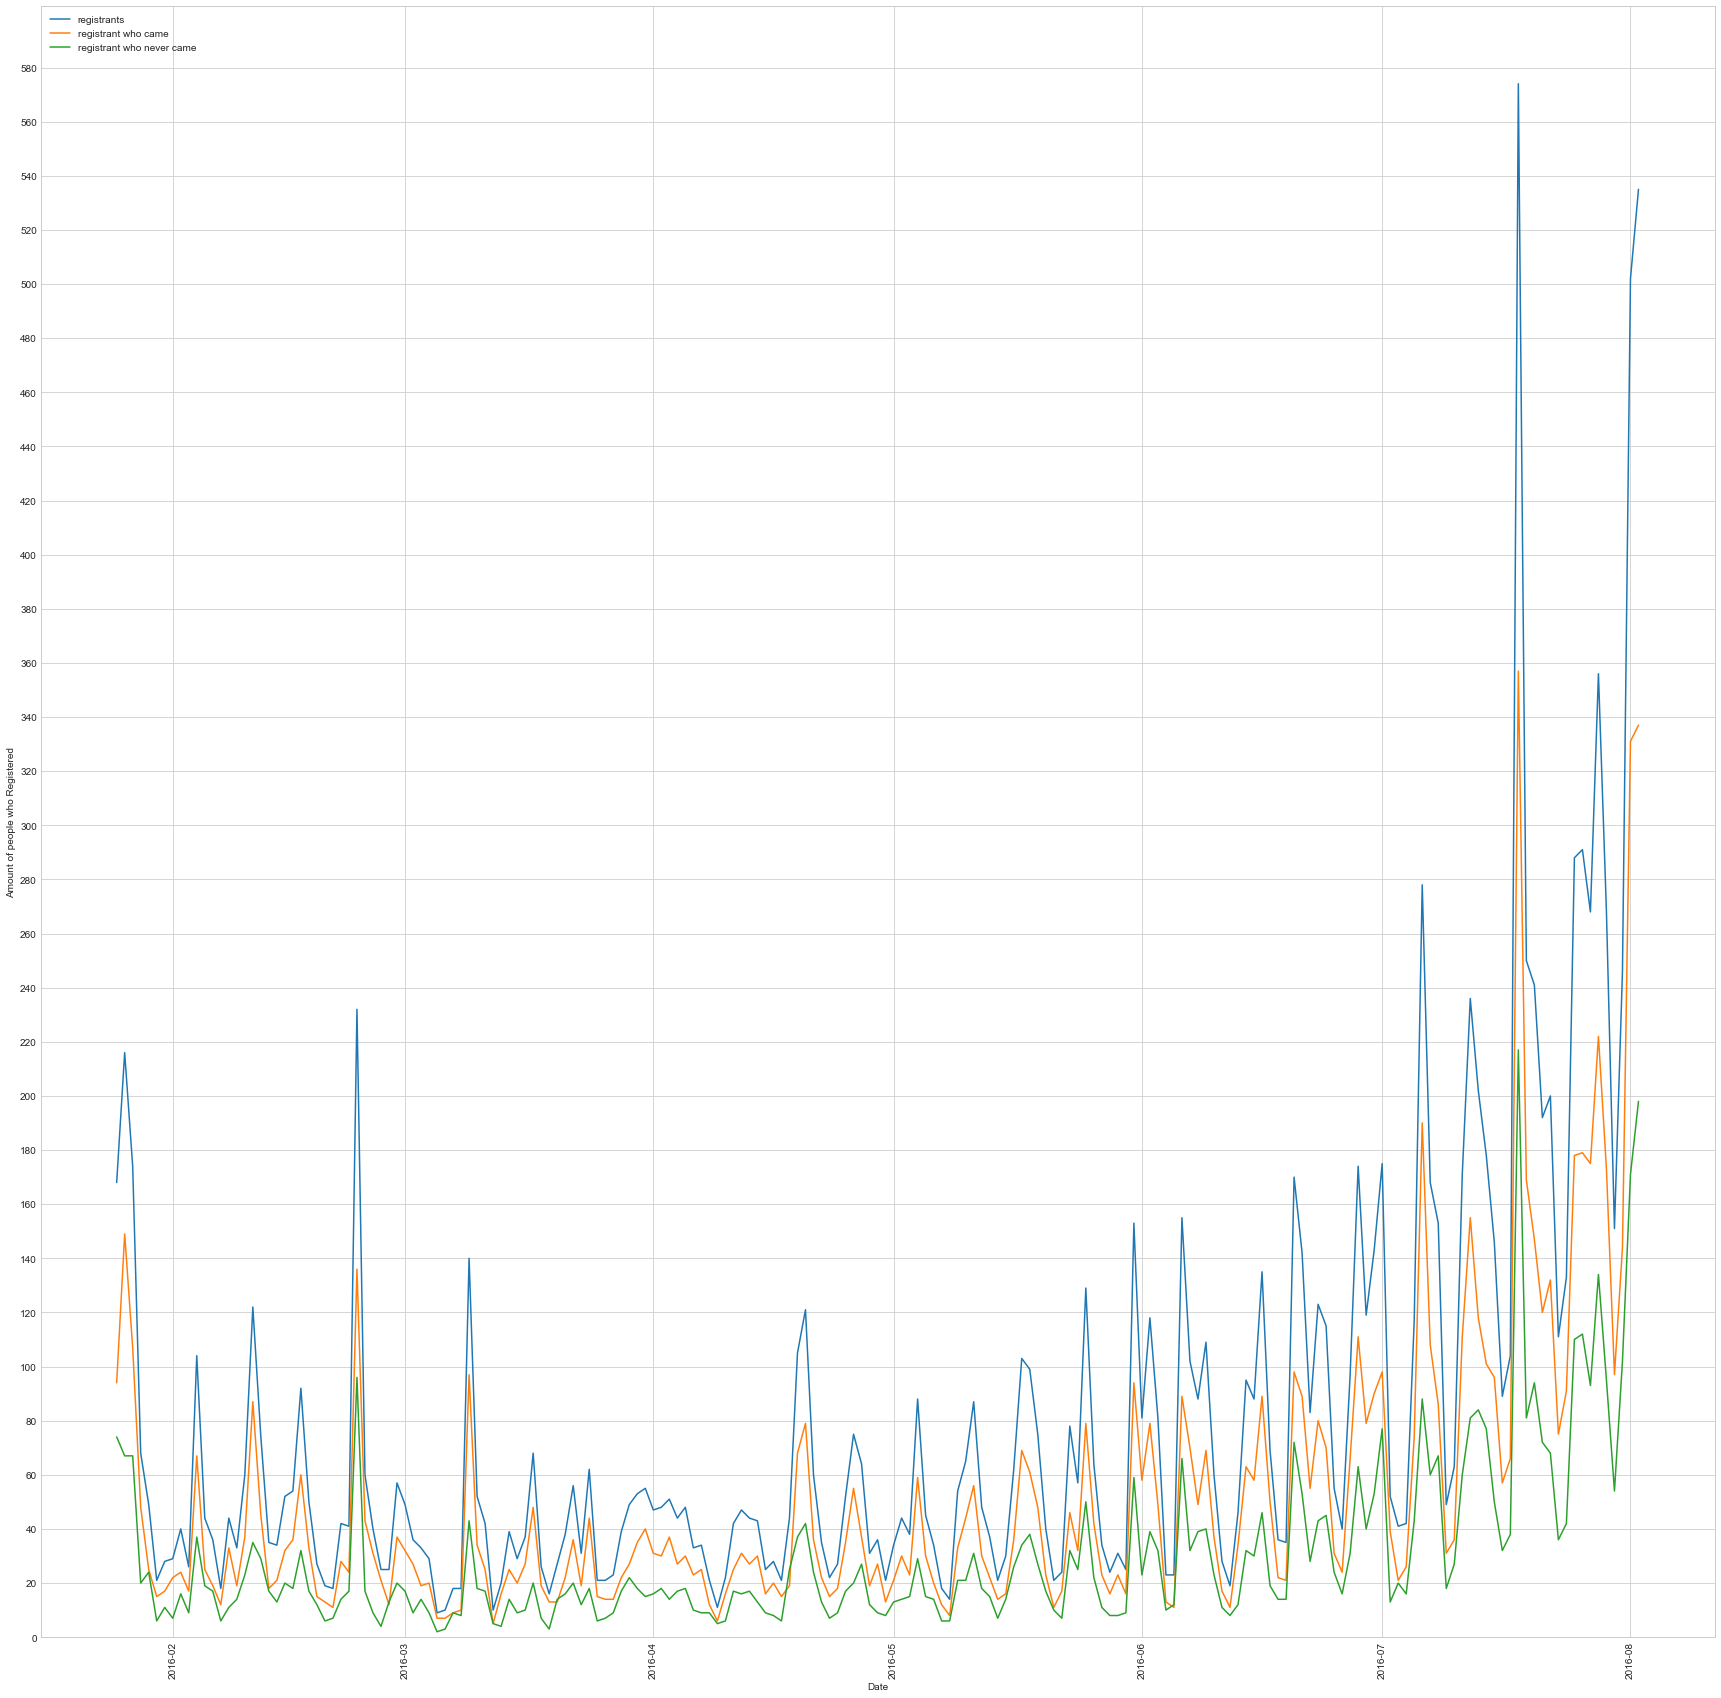

In [63]:
plt.figure(figsize=(30, 30))# people who registered on that day
plt.plot(plotting.index,plotting.values, label = 'registrants' )
plt.plot(plotting_come.index, plotting_come.values, label = 'registrant who came')
plt.plot(plotting_come.index, (plotting.values - plotting_come.values),label = 'registrant who never came')
plt.legend(loc='upper left')
plt.yticks(np.arange(0, 600, 20))
plt.xticks(rotation='vertical')
plt.ylim(ymin=0)
plt.xlabel('Date')
plt.ylabel('Amount of people who Registered')



In [64]:
registrants = {'Dates':plotting.index, 'Registrants': plotting.values, 'Registrants_Came': plotting_come.values, 'Registrants_Not_Come': (plotting.values-plotting_come.values), 'Percentage_Registrants_Who_Came':percentage}

In [65]:
Registrants_Excel = pd.DataFrame(data = registrants)

In [66]:
Registrants_Excel

,Dates,Percentage_Registrants_Who_Came,Registrants,Registrants_Came,Registrants_Not_Come
0,2016-01-25,0.559524,168,94,74
1,2016-01-26,0.689815,216,149,67
2,2016-01-27,0.614943,174,107,67
3,2016-01-28,0.705882,68,48,20
4,2016-01-29,0.510204,49,25,24
5,2016-01-30,0.714286,21,15,6
6,2016-01-31,0.607143,28,17,11
7,2016-02-01,0.758621,29,22,7
8,2016-02-02,0.600000,40,24,16
9,2016-02-03,0.653846,26,17,9


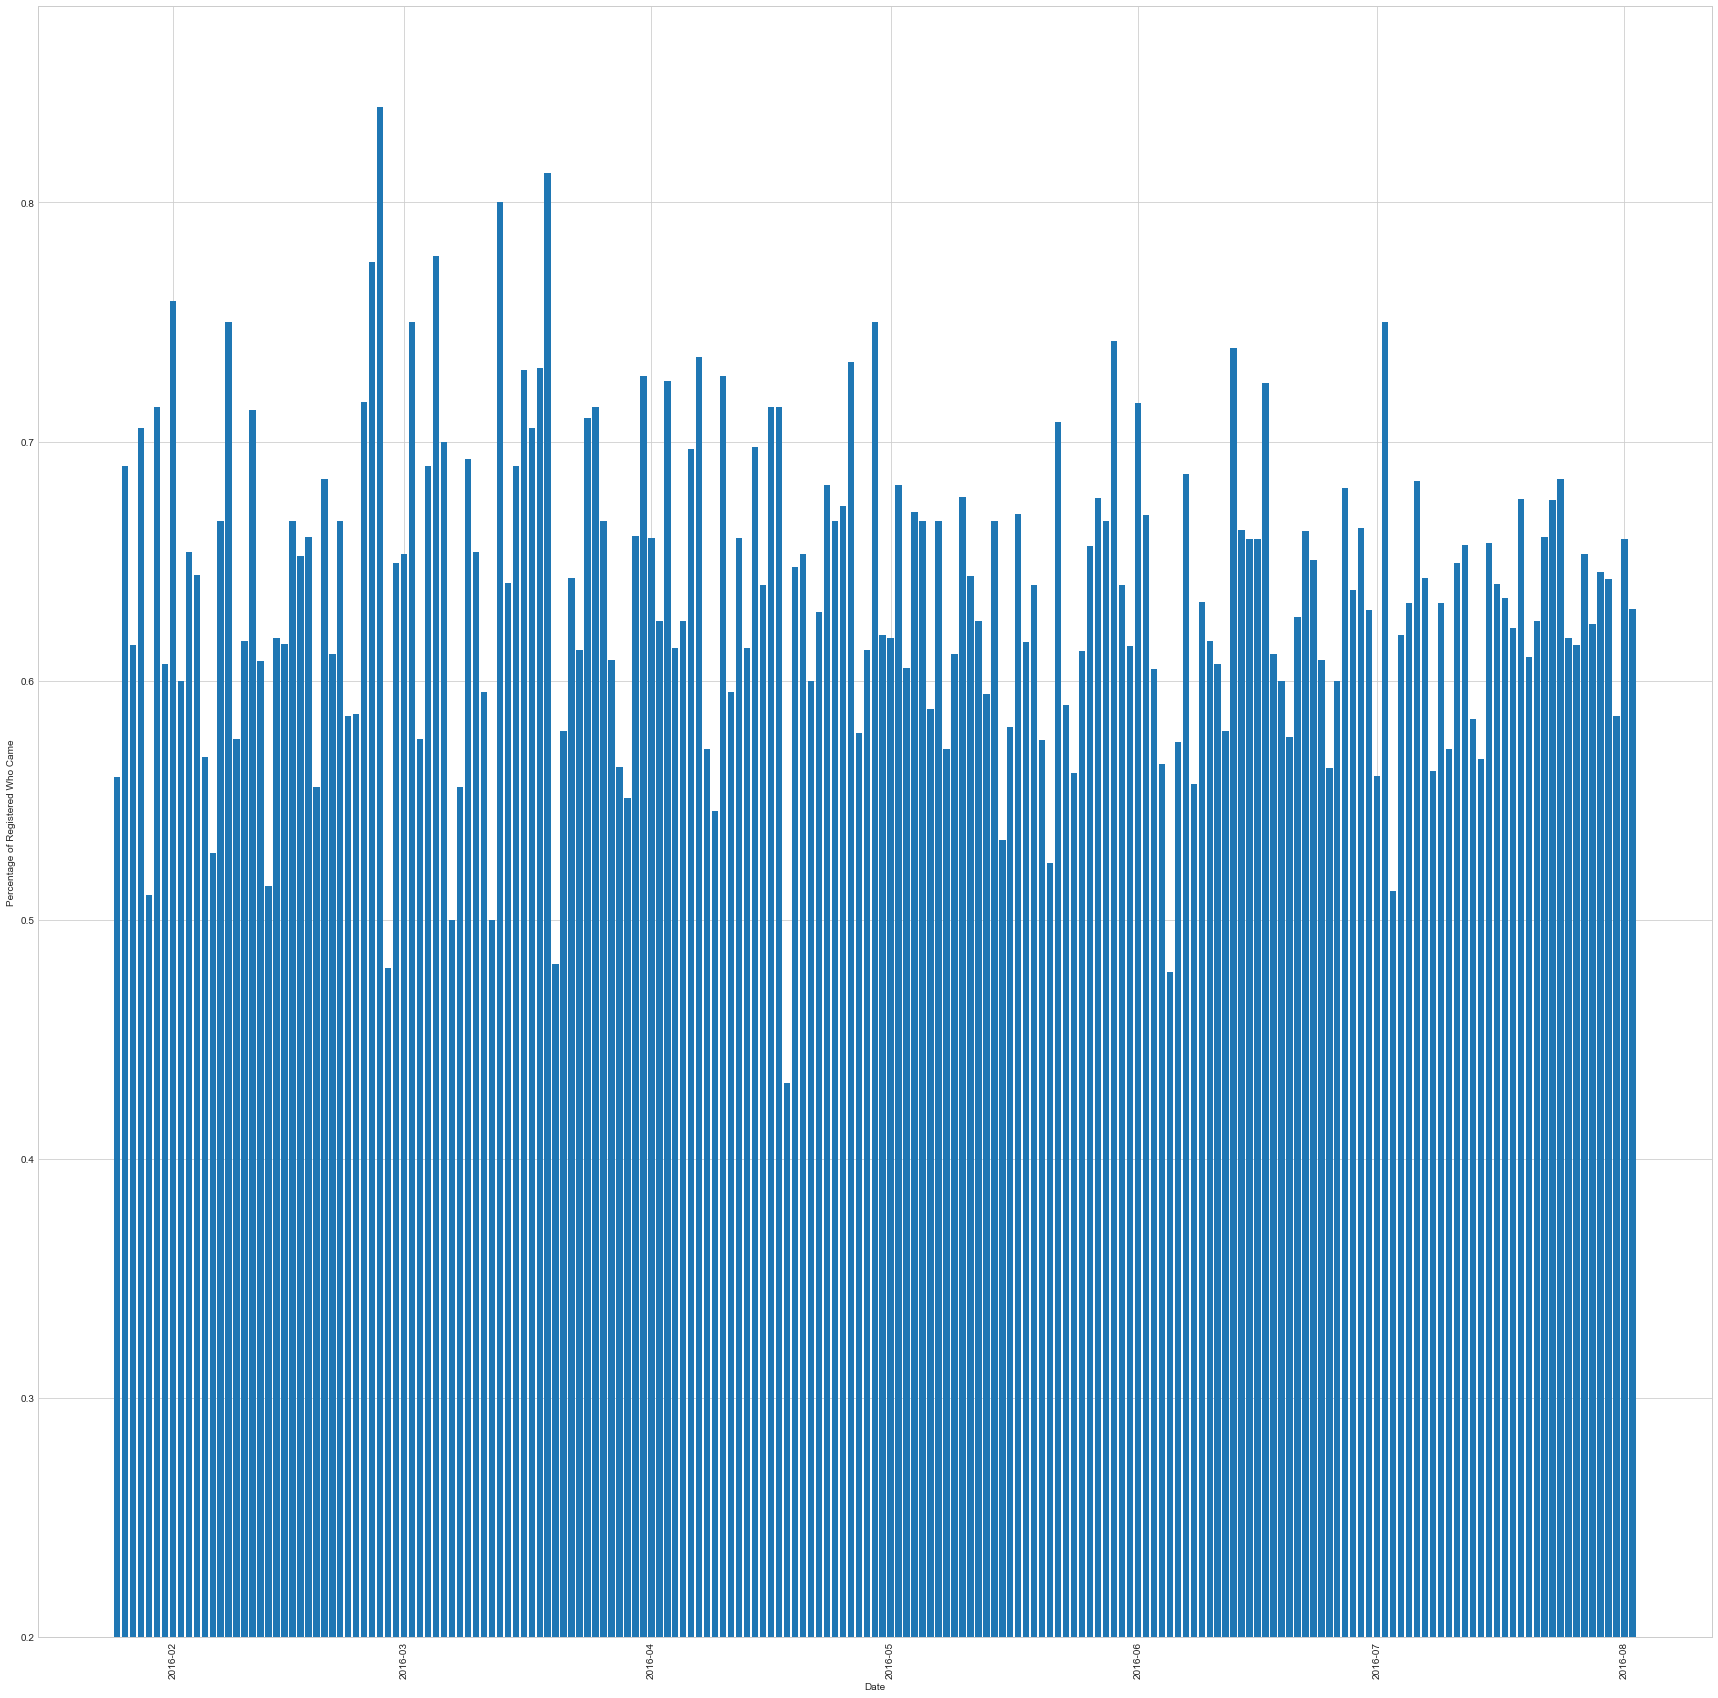

In [67]:
plt.figure(figsize=(30, 30))# people who registered on that day
plt.bar(plotting.index,percentage )
#plt.yticks(np.arange(0, 600, 20))
plt.xticks(rotation='vertical')
plt.ylim(ymin=.2)
plt.xlabel('Date')
plt.ylabel('Percentage of Registered Who Came')

In [ ]:
plt.figure(figsize=(60, 60))
plt.plot(plotting.index.sort_values(ascending=True), plotting)
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Percentage of Registered that Came to Event')

In [80]:
corr_X = pd.concat([train_T,train_Y],axis=1)

In [82]:
corr = corr_X.select_dtypes(include = ['int64', 'float64', 'uint8', 'bool']).iloc[:, 1:].corr()
plt.figure(figsize=(150, 150))
sns.heatmap(corr,vmin=-1, vmax=1, square=True)

In [41]:
import pandas_ml as pdml
import imblearn

In [42]:
train_Y = pd.DataFrame(train_Y)

In [43]:
data_normalized = pd.concat([train_X, train_Y], axis = 1)


In [44]:
data_normalized = pdml.ModelFrame(data_normalized, target = 0)

In [45]:
sampler = data_normalized.imbalance.over_sampling.SMOTE()
sampled = data_normalized.fit_sample(sampler)
sampled=pd.DataFrame(sampled)

In [46]:
sampled = sampled.sample(frac=1)
train_Y = sampled[0]
train_X = sampled.drop([0], axis = 1)

In [127]:
for a in train_X.columns:
    print a,train_X[a].value_counts().max()

Distance 1035
Company 8895
Phone1CountryPrefix 15497
Phone2Number 48
FaxCountryPrefix 7849
AmountBilled 14621
AmountPaid 14984
AmountDue 15987
0201 15472
0202 15632
0203 15671
0204 15143
0205 15055
0206 13045
0207 12473
0208 11498
0209 10506
0210 15492
0211 15362
0212 14181
0213 13964
0214 15478
0215 13223
0216 13298
0217 15661
0218 15567
0219 15144
0220 15013
0221 15393
0222 15285
0223 15380
0224 15766
0225 14998
0226 15687
0227 15419
0401 16340
0402 16366
0501 16374
0502 16365
0601 16382
0602 16365
0701 16344
0702 16382
1101 16383
1103 16374
1201 16197
1301 16194
1401 16194
1501 16194
1601 16282
1801 16301
1901 16359
1902 16285
2001 16336
2101 16367
2201 16352
2202 16367
2203 16320
2301 16377
2302 16386
2304 16295
2305 16385
2307 16387
2309 16379
2310 16387
2401 16373
2402 16382
2403 16309
3001 16385
3101 16383
3102 16384
3103 16349
3201 16370
3301 16361
3401 16367
3501 16376
3601 16336
3801 16371
3802 16377
3901 16386
3902 16371
4001 16377
4101 16358
4301 15849
4302 15578
4303 15908

In [ ]:
'Days_to_Event','Days_to_Event_Modify','TermsAccepted_accepted','Email_Username','AmountBilled','PET','Distance','CA', 'NV', 'AZ','TX','WA','CO','FL', 'UT', 'nan','NY','sum_response'

In [47]:
train_T = train_X[['0201', '0202','0203', '0204', '0205','0206','0207','0208','0209','0210','0211','0212', '0213', '0214', '0215', '0216', '0217', '0218', '0219', '0220','0221', '0222', '0223', '0224','0225', '0226', '0227','4301','4302','4303','4312','4313','4324','4329','4330', '403','aol.com','yahoo.com','hotmail.com','cox.net','MemberStatus_FullMember','AmountPaid', 'AmountDue','ATL', 'Company','Days_to_Event','Days_to_Event_Modify','TermsAccepted_accepted','Email_Username','AmountBilled','PET','Distance','CA', 'NV', 'AZ','TX','WA','CO','FL','UT','nan','NY','sum_response']]
#76% roc linnear regression

In [48]:
num_folds = 10
num_instances = len(train_T) 
seed = 7
scoring = 'roc_auc'

In [49]:
from sklearn.svm import LinearSVR

In [50]:
models=[]
models.append(('LR', LogisticRegression(random_state = seed)))
models.append(('LASSO', Lasso())) 
models.append(('Ridge', Ridge())) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))#ewights = 'distance' 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))
#models.append(('SVC', SVC(kernel = 'linear', random_state = seed)))
#models.append(('LinearSVR', LinearSVR(random_state = seed)))
for name, model in models:
    kfold = model_selection.KFold(shuffle = True, n_splits=num_folds, random_state=seed)
    
    cv_results = model_selection.cross_val_score(model, train_T, train_Y, cv=kfold, scoring = scoring)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.761563 (0.006766)
LASSO: 0.633607 (0.009629)
Ridge: 0.734782 (0.008900)

C:\Users\SuperBug\Anaconda2\envs\mdg\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")



LDA: 0.734785 (0.008920)
NB: 0.683878 (0.014041)
KNeighborsClassifier: 0.770947 (0.013639)
XGBClassifier: 0.832049 (0.010160)
GradientBoostingClassifier: 0.835937 (0.010246)
AdaBoostClassifier: 0.808848 (0.010412)
RandomForestClassifier: 0.850403 (0.006714)
ExtraTreesClassifier: 0.840355 (0.007108)
DecisionTreeClassifier: 0.773254 (0.011213)


In [54]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [51]:
train_P= test_X[['0201', '0202','0203', '0204', '0205','0206','0207','0208','0209','0210','0211','0212', '0213', '0214', '0215', '0216', '0217', '0218', '0219', '0220','0221', '0222', '0223', '0224','0225', '0226', '0227','4301','4302','4303','4312','4313','4324','4329','4330', '403','aol.com','yahoo.com','hotmail.com','cox.net','MemberStatus_FullMember','AmountPaid', 'AmountDue','ATL', 'Company','Days_to_Event','Days_to_Event_Modify','TermsAccepted_accepted','Email_Username','AmountBilled','PET','Distance','CA', 'NV', 'AZ','TX','WA','CO','FL','UT','nan','NY','sum_response']]

In [60]:
model =  LogisticRegression(random_state = seed)
model.fit(train_T, train_Y)
#test_preds = model.predict(test_X)
array = model.predict(train_T)
probab = model.predict_proba(train_T)


In [61]:
print metrics.accuracy_score(train_Y, array)
print metrics.roc_auc_score(train_Y, probab[:, 1])

0.676082977425
0.767948662874


In [ ]:
probab[3]

In [200]:
unique_elements, counts_elements = np.unique(array, return_counts=True)  # this is predictions
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1]
 [8201 8189]]


In [ ]:
unique_elements, counts_elements = np.unique(train_Y, return_counts=True) #this is actual
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

In [149]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [62]:
confusion_matrix(train_Y, array)

array([[4835, 3360],
       [1949, 6246]], dtype=int64)

In [156]:
estimator = LogisticRegression(random_state = seed)
rfe = RFECV(estimator,cv = kfold)
fit = rfe.fit(train_T,train_Y)
print("Num of feature: %d") % fit.n_features_
#print("Selected features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num of feature: 16
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
top_65_important_features = [] 
for b in range(0,len(fit.ranking_)):
    if fit.ranking_[b] == 1:
        top_65_important_features.append(b)
        print b,train_X.columns[b]

In [ ]:
new_X = train_X.iloc[:,top_65_important_features]

In [ ]:
X = new_X

In [ ]:
top_65_important_features = X

In [123]:
models=[]
models.append(('LR', LogisticRegression(random_state = seed)))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNeighborsClassifier', KNeighborsClassifier())) 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))
#models.append(('SVC', SVC(kernel = 'linear', random_state = seed)))
#models.append(('LinearSVR', LinearSVR(random_state = seed)))
for name, model in models:
    kfold = model_selection.KFold(shuffle = True, n_splits=num_folds, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, train_Y, cv=kfold, scoring= scoring)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

NameError: name 'X' is not defined

In [ ]:
y_test = pd.DataFrame({'y': y})

In [ ]:
Z=[]
Z=pd.concat([X,train_Y],axis=1)

In [ ]:
corr = Z.select_dtypes(include = ['int64', 'float64','uint8']).iloc[:, 1:].corr()

In [ ]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(60, 60))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin = -1, vmax=1, square=True)

In [ ]:

pd.set_option('display.max_columns', 500)

In [127]:
for a in range(0, len(models)):
    model1 = models[a]
    for b in range(a+1, len(models)):
        model2 = models[b]
        for c in range(b+1, len(models)):
            model3 = models[c]
            estimators = []
            estimators.append(model1)
            estimators.append(model2)
            estimators.append(model3)
            ensemble = VotingClassifier(estimators, voting='soft')
            results = model_selection.cross_val_score(ensemble, train_T, train_Y, cv=kfold, scoring= scoring)
            if results.mean() > .85:
                print(model1[0], model2[0], model3[0],results.mean(), results.std())


('LR', 'KNeighborsClassifier', 'RandomForestClassifier', 0.85369773310560304, 0.0074974399523090171)
('LR', 'KNeighborsClassifier', 'ExtraTreesClassifier', 0.85493828459381971, 0.0087903236616036669)
('LR', 'XGBClassifier', 'RandomForestClassifier', 0.85486887655878885, 0.0084441092122449091)
('LR', 'XGBClassifier', 'ExtraTreesClassifier', 0.85615346320586616, 0.0087860251358491352)
('LR', 'GradientBoostingClassifier', 'RandomForestClassifier', 0.85548179096871357, 0.0087556884215473311)
('LR', 'GradientBoostingClassifier', 'ExtraTreesClassifier', 0.85671676466978164, 0.0090803949059594762)
('LR', 'AdaBoostClassifier', 'RandomForestClassifier', 0.85188208214529548, 0.0088626699608252077)
('LR', 'RandomForestClassifier', 'ExtraTreesClassifier', 0.85688839965691055, 0.0093673845581198571)
('LDA', 'XGBClassifier', 'ExtraTreesClassifier', 0.85002648382492585, 0.0097600352542832527)
('LDA', 'GradientBoostingClassifier', 'ExtraTreesClassifier', 0.85067654632557921, 0.0099652017836868688)
('L

In [144]:
estimators = []

estimators.append(('LR',LogisticRegression(random_state = seed)))
estimators.append(('XGBClassifier',xgb.XGBClassifier()))
estimators.append(('KNeighborsClassifier', KNeighborsClassifier()))
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(train_T, train_Y)
predict = ensemble.predict(test_P)
probab = ensemble.predict_proba(test_P)

In [139]:
results = model_selection.cross_val_score(ensemble, train_T, train_Y, cv=kfold, scoring= scoring)

In [ ]:
estimators = ('LR', LogisticRegression(random_state = seed)'LR', 'XGBClassifier', 'RandomForestClassifier', 0.85486887655878885

In [ ]:
RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))

In [63]:
test_P = test_X[[ '0201', '0202','0203', '0204', '0205','0206','0207','0208','0209','0210','0211','0212', '0213', '0214', '0215', '0216', '0217', '0218', '0219', '0220','0221', '0222', '0223', '0224','0225', '0226', '0227','4301','4302','4303','4312','4313','4324','4329','4330', '403','aol.com','yahoo.com','hotmail.com','cox.net','MemberStatus_FullMember','AmountPaid', 'AmountDue','ATL', 'Company','Days_to_Event','Days_to_Event_Modify','TermsAccepted_accepted','Email_Username','AmountBilled','PET','Distance','CA', 'NV', 'AZ','TX','WA','CO','FL','UT','nan','NY','sum_response']]

In [69]:
model =  LogisticRegression(random_state = seed)
model.fit(train_T,train_Y)
predict = model.predict(test_P)
probab = model.predict_proba(test_P)

In [70]:
print metrics.accuracy_score(test_Y, predict)
print metrics.roc_auc_score(test_Y, probab[:, 1])

0.730911931263
0.739916173286


In [71]:
confusion_matrix(test_Y, predict)

array([[1523, 1593],
       [1163, 5963]], dtype=int64)

In [ ]:
c = 0
e = 0
for idx, val in enumerate(probab):
    if val[0] > .80:
        c += 1
        if test_Y[idx] == 0:
            print c, 0, idx, val[0]
        else: 
            e += 1
            print c, 0, idx, val[0], "error"
            
   
    if val[1] > .80:
        c += 1
        if test_Y[idx] == 1:
            print c, 1, idx, val[1]
        else:
            e += 1
            print c, 1, idx, val[1], "error"
print e
        


In [ ]:
from sklearn import metrics

In [ ]:
estimators = []
estimators.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
estimators.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
estimators.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(X, train_Y)
predict = ensemble.predict(test_X[X.columns])
probab = ensemble.predict_proba(test_X[X.columns])

In [ ]:
print metrics.accuracy_score(test_Y, predict)
print metrics.roc_auc_score(test_Y, probab[:, 1])

In [ ]:
print metrics.confusion_matrix(test_Y, predict)
#print metrics.classification_report(test_Y, predict)